# Parker Dunn

__Assignment for COURSERA: Introduction to Deep Learning (via CU Boulder)__  
__Assignment:__ Week 3 - CNN Cancer Detection Kaggle Mini-Project

In [ ]:
# CONNECTING TO GOOGLE DRIVE & KAGGLE DATA

import os
import shutil

print("Working directory...")
!pwd

from google.colab import drive
drive.mount('/content/drive')

os.environ['KAGGLE_CONFIG_DIR'] = "drive/MyDrive"
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -q histopathologic-cancer-detection.zip

Working directory...
/content
Mounted at /content/drive
100% 6.30G/6.31G [01:44<00:00, 68.2MB/s]
100% 6.31G/6.31G [01:44<00:00, 65.1MB/s]


In [ ]:
# RE-ARRANGING THE IMAGE FILES TO BE COMPATIBLE WITH tf.keras.utils.images_from_directory...

!mkdir train/pos
!mkdir train/neg

import pandas as pd
import numpy as np
from skimage import io

y_info = pd.read_csv("train_labels.csv", header=0)

for i in range(y_info.shape[0]):
  f = y_info.loc[i,"id"]
  img = io.imread("train/"+f+".tif")

  if y_info.loc[i,"label"]:   # "== 1"
    io.imsave("train/pos/"+f+".jpg", img, check_contrast=False, quality=100)
    os.remove("train/"+f+".tif")
  else:
    os.remove("train/"+f+".tif")
    io.imsave("train/neg/"+f+".jpg", img, check_contrast=False, quality=100)

test_locs = os.listdir("test/")

for i in range(5):
  print(test_locs[i])

count = 0
for ff in test_locs:
    img = io.imread("test/"+ff)
    if (count < 3):
      print(img.shape)
      print(f"test/{ff[:-4]}.jpg")
      count += 1
    io.imsave("test/"+ff[:-4]+".jpg", img, check_contrast=False, quality=100)
    os.remove("test/"+ff)

a691ec5370de90eba32987009ec3ce44ab035ce8.tif
89b91e9ddcb436bc58449f6d02d3a6b1ae111fcc.tif
f2cab828677885357d217aa382736c9f57b67a31.tif
de73030a1700950008cbb063be83e36c478d4eea.tif
5271fa4a502af680cd688abc1b38efdf2976ecce.tif
(96, 96, 3)
test/a691ec5370de90eba32987009ec3ce44ab035ce8.jpg
(96, 96, 3)
test/89b91e9ddcb436bc58449f6d02d3a6b1ae111fcc.jpg
(96, 96, 3)
test/f2cab828677885357d217aa382736c9f57b67a31.jpg


___
## Section 3 - Model Architecture

#### Plan

I'll stick to a simple model. I plan to use the "building block-style" Covolution-Convolution-Pooling design pattern with probably no more than 4 repetitions of this pattern. Since we previously experimented with the development of neural network architecture, I am hoping to replicate a reliable NN structure from one of the example image classification models from the videos. In theory, the key features will be extracted by the convolution architecture and the NN structure from another image classification task can be successfully optimized for new features.

Laid out below are my achitecture plans as well as some of the thoughts I have regarding the training of my CNN.

__Design parameters and Hyperparameters__
Decisions
* I will use ReLU (hidden layers) and sigmoid (output layer) as activation functions. This is not a design parameter that I plan to vary this time.
* I will primarily use 3x3 convolutional filters
* As an optimization method, I will stick to SGD with momentum because I am most familiar with SGD

--- __*Update*__ ---
* Decided to change optimizer: SGD -> Adam
  - I was looking for ways to improve my results and Adam was suggested
  - I'm going to use the default values for the parameters that I am not familiar with: "beta_1", "beta_2", "epsilon"

Hyperparameters
* Learning rate
    * Test: 0.01 | 0.001 | 0.0001 (3 values)
* Momentum
    * Test: 0.0 | 0.01 | 0.1 (3 values)
* Number of epochs (i.e., how much training)

Design
* Number of [Conv-Conv-Pool] layers
    - Test: 2, 3, 4
* Number of filters to use

Potential ways to improve a struggling model
* L2 regularization
* Batch normalization

I plan to use moderate training parameters at first (e.g. learning rate -> 0.001 and momentum -> 0.01) to experiment and narrow down some viable convolution designs.

___
#### Step 3 - Part 1: Loading packages, defining variables, and loading data

Trying to find a repeatable way to create a CNN!

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

from datetime import datetime
import json
import pathlib

# import os
# import shutil
# from skimage import io
import pandas as pd
import numpy as np

import glob
import matplotlib.pyplot as plt
import seaborn as sns



# CRITICAL VARIABLES

PATH="drive/MyDrive/IntroToDL_CancerMiniProject/"
TRAIN = pathlib.Path("train/")
TEST= pathlib.Path("test/")

batch_size=64
img_dim=96

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# Loading the image data

train_locs=glob.glob("train/*/*.jpg")
image_count = len(train_locs)
print(f"Image Count: {image_count}")


train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN,
    validation_split=0.33,
    subset="training",
    seed=123,
    image_size=(img_dim, img_dim),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN,
    validation_split=0.33,
    subset="validation",
    seed=123,
    image_size=(img_dim, img_dim),
    batch_size=batch_size)

# test_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST,
#     image_size=(img_dim, img_dim))

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# for image_batch, labels_batch in test_ds:
#   print(image_batch.shape)
#   print(labels_batch.shape)
#   break

test_dir_files = os.listdir(TEST)
for i in range(4):
  print(test_dir_files[i])

Image Count: 220025
Found 220025 files belonging to 2 classes.
Using 147417 files for training.
Found 220025 files belonging to 2 classes.
Using 72608 files for validation.
(64, 96, 96, 3)
(64,)
68005f6f36d29506e5dbfa20228fc100c7e12d9e.jpg
c6633e871be12066e21cacbef9fc792eed9de54f.jpg
ba94d2cb8d5d96227426b840b50561bcab495848.jpg
b03aff0f0d2c4391f72a32fac31239440729bf36.jpg


#### Step 3 - Part 2: Preparing functions to build model and preparing for training

* I tried to create a function that would allow me to quickly modify a list to change model parameters
* I normalized the images to a [0,1] scale
* I cropped the images since only the middle 32x32 pixel region of the images is used for classification
* I created a function to perform the model compilation process.


In [ ]:
## A FUNCTION THAT TAKES THE PARAMETERS ABOVE AND TURNS THEM INTO A MODEL!

def model_creator(layers_lst, layer_design):
    model = tf.keras.Sequential()
    model.add(layers.Rescaling(1./255))
    model.add(layers.Cropping2D(cropping=((12,12),(12,12)), data_format='channels_last'))

    for (l, d) in zip(layers_lst, layer_design):
        if l == "input":
            model.add(layers.Conv2D(d["filters"], d["kernel_size"], activation='relu', padding=d["padding"], input_shape=d["input_shape"]))
        elif l == "conv":
            model.add(layers.Conv2D(d["filters"], d["kernel_size"], activation='relu', padding=d["padding"]))
        elif l == "maxpool":
            model.add(layers.MaxPool2D(d["pool_size"], strides=d["strides"]))
        elif l == "flatten":
            model.add(layers.Flatten())
        elif l == "dense":
            model.add(layers.Dense(d["size"], activation=d["activation"]))
        elif l == "output":
            model.add(layers.Dense(d["size"]))
        elif l == "dropout":
            model.add(layers.Dropout(d["rate"]))
        elif l == "norm":
            model.add(layers.BatchNormalization(axis=3))  # not 100 percent sure 3 is correct
        elif l == "conv_pool":
            model.add(layers.Conv2D(d["filters"], d["kernel_size"], strides=d["strides"], padding=d['padding']))
        else:
            raise Exception("Invalid layer provided for the model")

    return model
        
# model.summary()

def model_compiler(model, opt_param, metrics):
    opt = optimizers.Adam(learning_rate=opt_param)
    # "from_logits=True" -- recommended by tf documentation
    model.compile(optimizer=opt,
                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=metrics)
    return model

#### Step 3 - Part 3: Testing model parameters

In [ ]:
layers_lst = ["input",
              "conv_pool",
              "norm",
              "conv",
              "conv",
              "maxpool",
              "norm",
              "conv",
              "conv",
              "maxpool",
              "norm",
              "flatten",
              "dense",
              "dropout",
              "dense",
              "dropout",
              "dense"
              ]
layer_design = [
    {"filters":16, "kernel_size":(7,7), "padding":"valid", "input_shape":(72,72,3)},
    {"filters":16, "kernel_size":(5,5), "strides":(2,2), "padding":"same"},
    None,
    {"filters":32, "kernel_size":(3,3), "padding":"same"},
    {"filters":32, "kernel_size":(3,3), "padding":"same"},
    {"pool_size":(2,2), "strides":(1,1)},
    None,
    {"filters":64, "kernel_size":(3,3), "padding":"same"},
    {"filters":64, "kernel_size":(3,3), "padding":"same"},
    {"pool_size":(2,2), "strides":(1,1)},
    None,
    None,
    {"size":128, "activation":'relu'},
    {"rate":0.2},
    {"size":64, "activation":'relu'},
    {"rate":0.2},
    {"size":1, "activation":'sigmoid'}]


Epoch 1/4
2304/2304 [==============================] - 88s 37ms/step - loss: 0.4491 - accuracy: 0.8012 - val_loss: 0.5767 - val_accuracy: 0.7020
Epoch 2/4
2304/2304 [==============================] - 85s 37ms/step - loss: 0.3650 - accuracy: 0.8416 - val_loss: 0.6588 - val_accuracy: 0.7223
Epoch 3/4
2304/2304 [==============================] - 87s 38ms/step - loss: 0.3287 - accuracy: 0.8608 - val_loss: 0.3856 - val_accuracy: 0.8303
Epoch 4/4
2304/2304 [==============================] - 87s 38ms/step - loss: 0.3015 - accuracy: 0.8746 - val_loss: 0.3855 - val_accuracy: 0.8406
--- Ending Accuracy --- 
 Validation: 84.06% 
 Training: 87.46% 



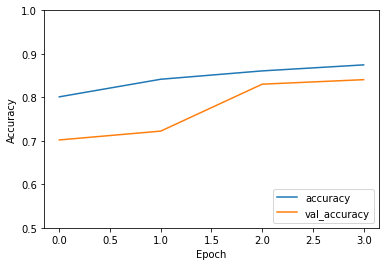

In [ ]:
# *********** CONFIGURE THE DATA FOR PEROFRMANCE ***********************

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ***********  STEPS TO CREATE THE MODEL  *****************************
model = model_creator(layers_lst, layer_design)
model = model_compiler(model, 0.001, ['accuracy'])

# history is kind of like results!
# history = model.fit(train_ds,
#                     validation_data=val_ds,
#                     epochs=10,
#                     steps_per_epoch=200
#                    )                              # Added steps_per_epoch to give me a little more control of the training process

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=4
                    )

# ************** VIEWING THE OUTPUTS ***********************
print("--- Ending Accuracy ---","\n",
      f"Validation: {history.history['val_accuracy'][-1]:.2%}","\n",
      f"Training: {history.history['accuracy'][-1]:.2%}","\n")

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

# *********** SAVING THE MODEL AND RESULTS *****************
now_obj = datetime.now()
now_date = now_obj.strftime("%Y_%m_%d")
now_time = (now_obj.hour * 3600) + (now_obj.minute * 60) + now_obj.second
now = f"{now_date}_{now_time}"

filename1=f"{now}_{int(history.history['val_accuracy'][-1] * 100)}.json"
filename2=f"{now}_layers.json"
filename3=f"{now}_design.json"


with open(f"{PATH}design_testing/{filename1}", "w") as write_file:
    model_json = model.to_json()
    json.dump(model_json, write_file)
    
with open(f"{PATH}design_testing/{filename2}", "w") as write_file:
    json.dump(layers_lst, write_file)

with open(f"{PATH}design_testing/{filename3}", "w") as write_file:
    json.dump(layer_design, write_file)

## Step 3 - Choices for Design

After testing many designs, I have decided to use the design below. You can find information about the other designs I have tested in the "design_testing" folder. I saved JSON files with information about each design tested.

Image Modification Layers:
* Adjust pixel intensities from [0,255] to [0,1]
* Crop input images to remove 24 px from height and width.

Convolution Layers:
* Conv2D -> 7x7 kernel & 16 filters
* Conv2D -> 5x5 kernel & 16 filters
* BatchNormalization
* Conv2D -> 3x3 kernel & 32 filters
* Conv2D -> 3x3 kernel & 32 filters
* MaxPool -> 2x2 region
* BatchNormalization
* Conv2D -> 3x3 kernel & 64 filters
* Conv2D -> 3x3 kernel & 64 filters
* MaxPool -> 2x2 region
* Batch Normalization

Arificial Neural Network:
* Dense -> 128
* Dropout -> 0.2
* Dense -> 64
* Dropout -> 0.2
* Dense -> 1 (with sigmoid acitvation function)

I noticed a couple trends that led me to choose this design. Using the chosen style for convolution layers - i.e., Conv-Conv-Pool, designs with many layers were inconsistent. In early layers, large filters and strides greater than one had better results with regard to training and validation accuracy.

It seems likely, with the right additions, that deeper networks would do a better job on this task. The deep ImageNet models like LeNet and ResNet have a lot of success, but I was not able to use the `Sequential` model and include the connections that make these models successful. For the deeper designs tested, I concluded that high variance training and validation accuracy (see data at the beginning of step 4) were the result of the model complexity and ended up with a model with relatively few parameters.

Images provided are much larger than the regions used to classify them. My initial approach was to crop most of the unneeded region. Later in the testing process, the model achieved better success when less of the image was cropped out, which was paired with 5x5 and 7x7 filters and larger strides. The larger filters and strides were used in the first Conv-Conv-Pool block of my final design as a result.

# NEXT UP: Section 4: Results and Analysis

* I will solidify all parameters of the model via hyperparameter tuning.
* I will train a model on all data to generate a final model.